In [29]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

def gini_for_class_counts(counts):
    """
    TAKES: counts 
    RETURNS: Gini impurity of these counts in format of a single number.
    USED: in combine_gini
    
    Counts = array how many samples there are of each class = [3, 2, 1] (for example, 3 samples of class 0, 2 of class 1, 1 of class 2)
    Gini impurity measures how "mixed" the classes are.
    - If everything is the same class, Gini is 0.
    - The more mixed up the classes, the closer Gini gets to 1.
    """
    
    total_samples = counts.sum()
    if total_samples == 0:
        return 0.0

   
    probs = counts / total_samples # Fraction of each class = probability of that class(p_i)
    

    return 1.0 - np.sum(probs ** 2) # GINI = 1 - sum(p_i^2)

def combine_gini(left_counts, right_counts):
    """
    TAKES: counts(array of how many samples of each class) of left and right groups
    RETURNS: combined Gini impurity(one number, lower is better) of these counts in format of a single number. In other words, gini split
    USED: iteratively in find_best_split
    
    This function computes the combined Gini impurity of the two groups,
    weighted by how large each group is.
    """
    left_total = left_counts.sum() # total number of instances of all classes in left group (to weight the Gini values)
    right_total = right_counts.sum() # in right group
    combined_total = left_total + right_total # total number of all instances in both groups

    if combined_total == 0: # if empty -> avoid /0
        return 0.0

   
    gini_left = gini_for_class_counts(left_counts)
    gini_right = gini_for_class_counts(right_counts)

   
    return (left_total / combined_total) * gini_left + (right_total / combined_total) * gini_right  # Weighted average of the two Gini values

def find_best_split(X, y):
    """
    TAKES: 
    X: The features for each sample (normalized gray scale pixel intensities).
    y: The label for each sample (the class it belongs to).
    

    RETURNS: 
    best_feature_index: Which 'column' of X we split on. in range of 0 to 784 or 0 to 1 normalized
    best_threshold: The value in that column to compare against. in range of 0 to 1
    left_indices: The positions of the samples that go to the "left" group. in form of array
    right_indices: The positions of the samples that go to the "right" group. in form of array
    
    NOT SURE IF NECESSARY TO RETURN  best_gini:, where I gonna use it? 

    If no good split is found, it will return Nones
    """
    best_feature_index = None
    best_threshold = None
    left_indices = None
    right_indices = None
    best_gini = 1.0  # 1.0 is the worst possible Gini

   
    num_samples, num_features = X.shape 


    for feature_idx in range(num_features): # for each feature 
  
        sorted_positions = np.argsort(X[:, feature_idx])# sort values and labels by (same) feature index,  
                                                        # takes O(n log n) time, but it's worth it because it's only once per feature and allow to avoid slicing
                                                        # I prefer not to do it this way, but it takes forever to build even one shallow tree, don't even start with evaluation
        sorted_values = X[sorted_positions, feature_idx]
        sorted_labels = y[sorted_positions] 
        #left = data[data[:, col] < value] this IS TOO SLOW, so we sort the data once and build prefix_counts array

        
        
        prefix_counts = np.zeros((num_samples + 1, 5), dtype=int) # 5 is the number of classes
        # prefix_counts[i] will contain the cummulative counts of each class up to position i in form of [0, 0, 0, 0, 0]
        for i in range(num_samples):
            prefix_counts[i + 1] = prefix_counts[i] # copy the previous row
            prefix_counts[i + 1][sorted_labels[i]] += 1 # add the current label to the counts

       
        for i in range(1, num_samples):
            if sorted_labels[i] == sorted_labels[i - 1]:  # check potential splits only where the label changes from one sample to the next
                continue

         
            threshold = 0.5 * (sorted_values[i] + sorted_values[i - 1]) #  average of the two values, f.x. 0.5*(0.2+0.3) = 0.25, so we split at 0.25
           
            left_group_counts = prefix_counts[i] # all samples up to i, takes O(1) because no slicing
            
            right_group_counts = prefix_counts[num_samples] - left_group_counts # everything else 

            current_gini = combine_gini(left_group_counts, right_group_counts) # new gini to check if it's better

            if current_gini < best_gini: #if better -> update
                best_gini = current_gini
                best_feature_index = feature_idx
                best_threshold = threshold
                left_indices = sorted_positions[:i]
                right_indices = sorted_positions[i:]

    return best_feature_index, best_threshold, left_indices, right_indices # don't have to return best_gini in the end I guess

def most_common_label(y):
    """
    TAKES: y (array of labels)
    RETURNS: The most common label(class) in 'y'(integer)
    USED: in build_tree in leaf node cases
    
    Finds which class occurs the most in 'y' and returns it.
    """
    return np.bincount(y).argmax()

def build_tree(X, y, max_depth, depth=0):
    """
    TAKES: 
    X: The features for each sample in the current subset.
    y: The label for each sample in the current subset.
    max_depth
    depth: current depth, initially 0, to check depth < max_depth
    RETURNS:
    tree in form of dictionary of dictionaries, int(most common class) for leaves
        
    Builds a decision tree by recursively splitting the data.
    
    USED: in many places ########

    """

    # STOP conditions:
    # 1) no data left
    # 2) max depth reached
    # 3) same class in all samples
    
    if len(y) == 0 or depth == max_depth or np.all(y == y[0]):
        return most_common_label(y)

    # Attempt to find the best place to split
    feat_idx, threshold, left_idx, right_idx = find_best_split(X, y)

   
    if feat_idx is None:  # no split was found -> return most common label 
        return most_common_label(y)

    
    left_subtree = build_tree( # otherwise, go deeper
        X[left_idx], 
        y[left_idx],    
        max_depth,
        depth + 1
    )
    right_subtree = build_tree(
        X[right_idx], 
        y[right_idx],
        max_depth,
        depth + 1
    )

                                            ###########
    return {                                # this is how it looks like
        'feature': feat_idx,                #     o -feature, threshold
        'threshold': threshold,             #    / \  -left, right splits on subtrees                  
        'left': left_subtree,               #   o   o -left(feauture, threshold, left, right) -right(feauture, threshold, left, right)
        'right': right_subtree              ########## and so on
    }




def classify_one_sample(tree, sample):
    """
    TAKES: our prebuilt tree and one sample(array of features) to classify
    RETURNS: the predicted class label for that sample (integer)
    USED: in predict function
    
    recursively traverses the tree, until leaf reached to find the class label for the sample.
    """
   
    if not isinstance(tree, dict): # stop condition, if we are in a leaf node -> return the class, else -> go deeper
        return tree
   

    
    if sample[tree['feature']] < tree['threshold']: #go left or right down the tree recursively
        return classify_one_sample(tree['left'], sample)
    else:
        return classify_one_sample(tree['right'], sample)

#


# I haven't found the way to avoid OOP compltely and still be able to use scikit pipeline for evaluation
# double for loop to check possible PCAs and max_depths takes forever
# -> so this is the class wrapper for the functions above
# decision tree already created from scratch, without classes
# class is necessary solely for evaluation(pipeline and heatmap), not training or prediction, so we allowed to use BaseEstimator, ClassifierMixin

class MyDecisionTree(BaseEstimator, ClassifierMixin):
    """
    wrapper for functional implementation of decision tree
    
    BaseEstimator is a base class for all estimators in scikit-learn.
    ClassifierMixin is a mix-in class for all classifiers in scikit-learn.
    
    fit(X, y) - train the model, stores it in self.tree_
        takes known data: X - feature M(feautures x samples) y - labels
    predict(X) - predict the labels, uses self.tree_
        takes X - feature M for unknown samples
        
    get_params - necessary for scikit-learn pipeline
    set_params - necessary for scikit-learn pipeline
    
    """

    def __init__(self, max_depth=3): 
        self.max_depth = max_depth
        self.tree_ = None

    def fit(self, X, y):
        self.tree_ = build_tree(X, y, self.max_depth, depth=0)
        return self 

    def predict(self, X):
        """
        Predict the label for each row in X by traversing self.tree_.
        """
        predictions = [classify_one_sample(self.tree_, row) for row in X]
        return np.array(predictions)

    def get_params(self, deep=True): #
        """
        Necessary for scikit-learn, so we can do hyperparameter searches 
        (like GridSearchCV).
        """
        return {"max_depth": self.max_depth}

    def set_params(self, **params): # ** allows passing multiple arguments
        """
        Allows setting our parameters from outside, e.g. in GridSearchCV.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self


              precision    recall  f1-score   support

           0       0.76      0.73      0.74      1000
           1       0.95      0.91      0.93      1000
           2       0.74      0.75      0.75      1000
           3       0.79      0.85      0.82      1000
           4       0.58      0.59      0.58      1000

    accuracy                           0.76      5000
   macro avg       0.77      0.76      0.76      5000
weighted avg       0.77      0.76      0.76      5000

[[728  12  28  86 146]
 [  7 908  19  47  19]
 [ 20   6 751  34 189]
 [ 39  15  30 847  69]
 [170  10 181  52 587]]


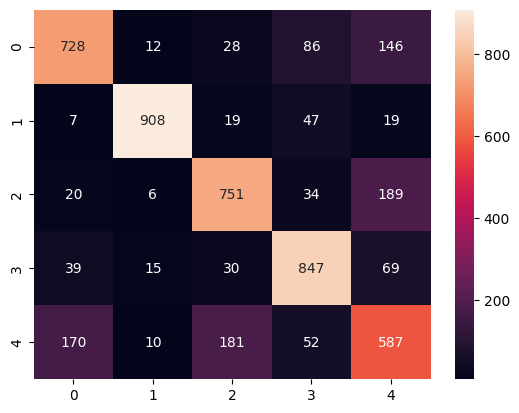

In [30]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

train_data = np.load('MLProject2024/fashion_train.npy')
test_data = np.load('MLProject2024/fashion_test.npy')

train_images = train_data[:, :-1] 
train_labels = train_data[:, -1].astype(int)
test_images = test_data[:, :-1]
test_labels = test_data[:, -1].astype(int)

#normalizing
mean = np.mean(train_images, axis=0)
std = np.std(train_images, axis=0)
train_images = (train_images - mean) / std
test_images = (test_images - mean) / std 



decision_tree = MyDecisionTree(max_depth=10)


# # #pca = 10/max_depth = 10
pca = PCA(n_components=110)
pca.fit(train_images)
train_pca_images = pca.transform(train_images)
test_pca_images = pca.transform(test_images)
decision_tree = MyDecisionTree(max_depth=10)
decision_tree.fit(train_pca_images, train_labels)
predictions = decision_tree.predict(test_pca_images)

print(classification_report(test_labels, predictions))

print(confusion_matrix(test_labels, predictions))
#fancy confusion matrix

sns.heatmap(confusion_matrix(test_labels, predictions), annot=True, fmt='d')
plt.show()



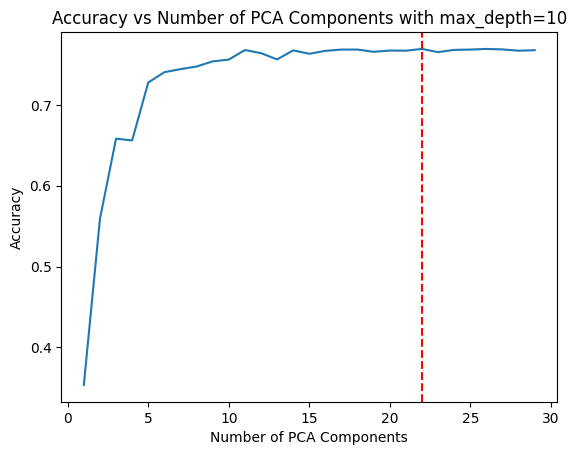

best accuracy: 0.7692 with 22 PCA components


In [26]:
#test for different PCAs with fixed max_depth=10
from sklearn.metrics import accuracy_score as accuracy
accuracyDict = {}
for i in range(1,30):
    pca = PCA(n_components=i)
    pca.fit(train_images)
    train_pca_images = pca.transform(train_images)
    test_pca_images = pca.transform(test_images)

    decision_tree = MyDecisionTree(max_depth=10)
    decision_tree.fit(train_pca_images, train_labels)
    predictions = decision_tree.predict(test_pca_images)
    accuracyDict[i] = accuracy(test_labels, predictions)
    

import matplotlib.pyplot as plt
plt.plot(list(accuracyDict.keys()), list(accuracyDict.values()))
plt.xlabel('Number of PCA Components');
plt.ylabel('Accuracy');
plt.title('Accuracy vs Number of PCA Components with max_depth=10');
#show max accuracy
max_key = max(accuracyDict, key=accuracyDict.get)
plt.axvline(x=max_key, color='r', linestyle='--')

plt.show()
print(f"best accuracy: {accuracyDict[max_key]} with {max_key} PCA components")



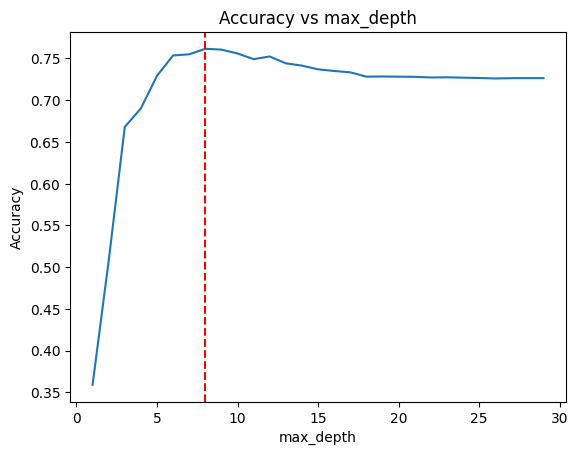

best accuracy: 0.7616 with max_depth=8 


In [11]:
#test for different max_depths with fixed PCA=10
pca = PCA(n_components=10)
pca.fit(train_images)
train_pca_images = pca.transform(train_images)
test_pca_images = pca.transform(test_images)
accuracyDict = {}
for i in range(1,30):

    decision_tree = MyDecisionTree(max_depth=i)
    decision_tree.fit(train_pca_images, train_labels)
    predictions = decision_tree.predict(test_pca_images)
    accuracyDict[i] = accuracy(test_labels, predictions)

plt.plot(list(accuracyDict.keys()), list(accuracyDict.values()))
plt.xlabel('max_depth');
plt.ylabel('Accuracy');
plt.title('Accuracy vs max_depth');
#show max accuracy
max_key = max(accuracyDict, key=accuracyDict.get)
plt.axvline(x=max_key, color='r', linestyle='--')


plt.show()
print(f"best accuracy: {accuracyDict[max_key]} with max_depth={max_key} ")
    


In [33]:
#cross validation
from sklearn.model_selection import cross_val_score, KFold
k_folds = KFold(n_splits = 5)

scores = cross_val_score(MyDecisionTree(max_depth=10), train_pca_images, train_labels, cv=k_folds)


scores.mean() # average accuracy


0.7636999999999999

best accuracy: 0.7676 with 0 PCA components
best accuracy with PCA: 0.7562 with 17 PCA components


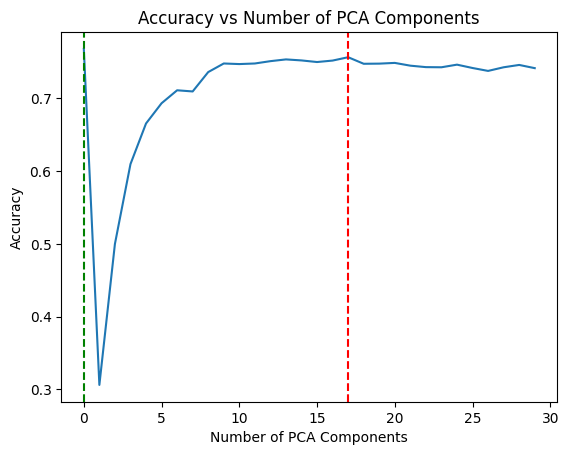

In [34]:
######
# sklearn reference implementation
######


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import balanced_accuracy_score as balanced_accuracy

import numpy as np

train_data = np.load('MLProject2024/fashion_train.npy')
test_data = np.load('MLProject2024/fashion_test.npy')

train_images = train_data[:, :-1] 
train_labels = train_data[:, -1].astype(int)
test_images = test_data[:, :-1]
test_labels = test_data[:, -1].astype(int)
#scailng
train_images = train_images / 255.0
test_images = test_images / 255.0

accuracyDict = {}
#no pca

decision_tree_sklearn = DecisionTreeClassifier()

decision_tree_sklearn.fit(train_images, train_labels)
predictions = decision_tree_sklearn.predict(test_images)
accuracyDict[0] = accuracy(test_labels, predictions)



#wit pca 1-30 

for i in range(1,30):
    pca = PCA(n_components=i)
    pca.fit(train_images)
    train_pca_images = pca.transform(train_images)
    test_pca_images = pca.transform(test_images)

    decision_tree_sklearn.fit(train_pca_images, train_labels)
    predictions = decision_tree_sklearn.predict(test_pca_images)
    accuracyDict[i] = accuracy(test_labels, predictions)
    

import matplotlib.pyplot as plt
plt.plot(list(accuracyDict.keys()), list(accuracyDict.values()))
plt.xlabel('Number of PCA Components');
plt.ylabel('Accuracy');
plt.title('Accuracy vs Number of PCA Components');
#show max accuracy
max_key = max(accuracyDict, key=accuracyDict.get)

print(f"best accuracy: {accuracyDict[max_key]} with {max_key} PCA components")
dict_without_nopca = {k: v for k, v in accuracyDict.items() if k != 0}  
dict_without_nopca
max_key_pca = max(dict_without_nopca, key=accuracyDict.get)
print(f"best accuracy with PCA: {dict_without_nopca[max_key_pca]} with {max_key_pca} PCA components")
plt.axvline(x=max_key, color='g', linestyle='--')
plt.axvline(x=max_key_pca, color='r', linestyle='--')
plt.show()
#plt.axvline(x=10, color='r', linestyle='--')


More or less same accuracy, but it works so much faster. Now heatmap.

In [ ]:
# makes sense to treat PCA as a hyperparameter as well as max_depth and find the best combination of them
# pipeline to find best hyperparameters(max_depth, pca components) for our decision tree
# running time ~ 1h at my machine for 25x25, makes sense to go deeper in PCA on faster machine 
# TBD: RuntimeWarning: invalid value encountered in cast   _data = np.array(data, dtype=dtype, copy=copy,


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score as accuracy
import numpy as np

train_data = np.load('MLProject2024/fashion_train.npy')
test_data = np.load('MLProject2024/fashion_test.npy')

train_images = train_data[:, :-1]
train_labels = train_data[:, -1].astype(int)
test_images = test_data[:, :-1]
test_labels = test_data[:, -1].astype(int)

#scaling
train_images = train_images / 255.0
test_images = test_images / 255.0


pipeline = Pipeline([
    ('pca', PCA()),
    ('decision_tree', MyDecisionTree())
])

parameters = {
    'pca__n_components': range(1, 26),
    'decision_tree__max_depth': range(1, 26)
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search.fit(train_images, train_labels)
print(grid_search.best_params_)
print(grid_search.best_score_)




c:\Programs\Anaconda\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'decision_tree__max_depth': 10, 'pca__n_components': 25}
0.7733000000000001


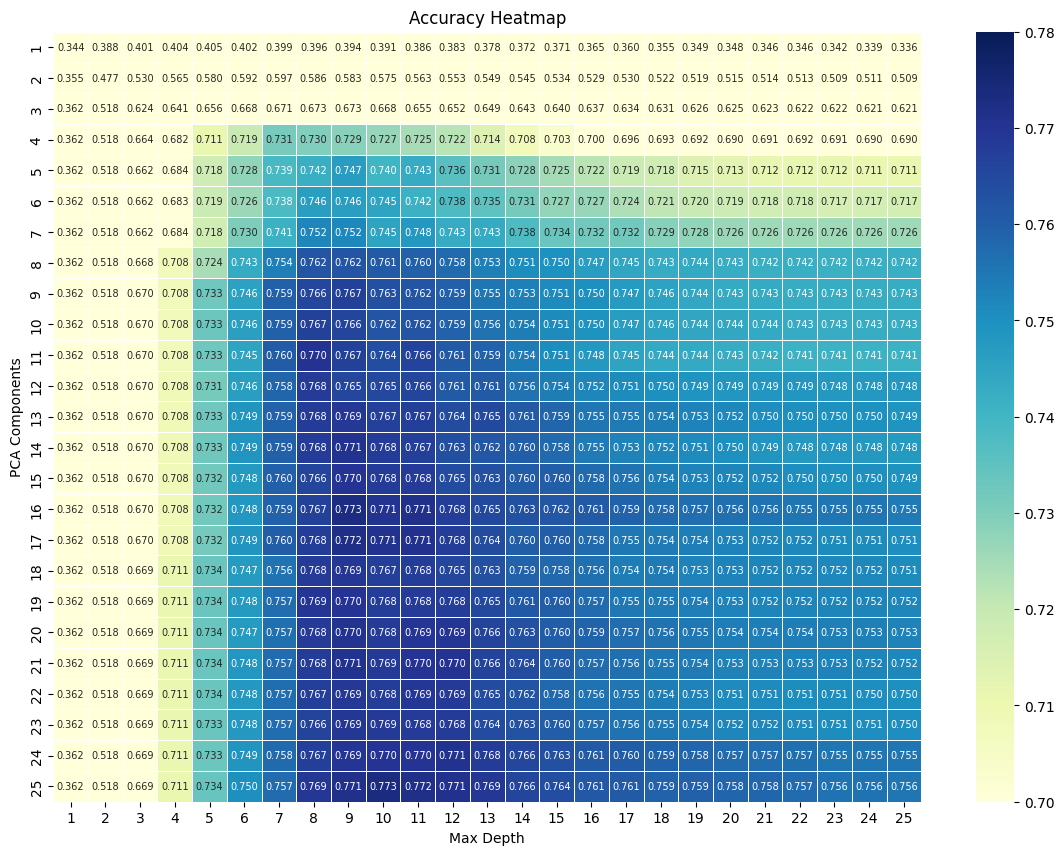

In [101]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

results = grid_search.cv_results_
param_df = pd.DataFrame(results['params'])
param_df['mean_test_score'] = results['mean_test_score']

heatmap_data = param_df.pivot(
    index='pca__n_components',
    columns='decision_tree__max_depth',
    values='mean_test_score'
)


plt.figure(figsize=(14, 10))  
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",  
    vmin=0.7,  
    vmax=0.78,  
    annot_kws={"size": 7},  
    linewidths=.5  
)


plt.xlabel('Max Depth')
plt.ylabel('PCA Components')
plt.title('Accuracy Heatmap')
plt.show()




In [13]:
#test for overfitting

from sklearn.metrics import accuracy_score as accuracy
import numpy as np

train_data = np.load('MLProject2024/fashion_train.npy')
test_data = np.load('MLProject2024/fashion_test.npy')

train_images = train_data[:, :-1]
train_labels = train_data[:, -1].astype(int)
test_images = test_data[:, :-1]
test_labels = test_data[:, -1].astype(int)

#scaling   
train_images = train_images / 255.0
test_images = test_images / 255.0

decision_tree = MyDecisionTree(max_depth=10)
decision_tree.fit(train_images, train_labels)
predictions = decision_tree.predict(train_images)
print("Train accuracy: ", accuracy(train_labels, predictions))

predictions = decision_tree.predict(test_images)
print("Test accuracy: ", accuracy(test_labels, predictions))

#overfitting, train accuracy is much higher than test accuracy




Train accuracy:  0.7587
Test accuracy:  0.6836
